### 1. 匯入套件與下載資料
匯入套件，並檢查執行環境是否支援 CUDA (GPU)。  
同時包含 Kaggle API 的設定流程，若資料夾不存在，會上傳 API Token (`kaggle.json`) 並下載、解壓縮 `animal-faces` 資料集。

In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, Subset
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import files
import os

# 檢查GPU是否可用
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'
print(f"Using device: {device}")

# 若資料集尚未存在,則上傳kaggle.json並下載
if not os.path.exists("animal-faces"):
    print("Upload kaggle.json...")
    files.upload() # 上傳kaggle.json

    # 設定Kaggle API權限並下載資料
    os.system("mkdir -p ~/.kaggle")
    os.system("cp kaggle.json ~/.kaggle/")
    os.system("chmod 600 ~/.kaggle/kaggle.json")
    os.system("kaggle datasets download andrewmvd/animal-faces")
    os.system("unzip -q animal-faces.zip -d animal-faces")
    print("Dataset downloaded and extracted.")

Using device: cpu
Upload kaggle.json...


Saving kaggle.json to kaggle.json
Dataset downloaded and extracted.


### 2. 定義影像轉換 (Transforms) 與建立 DataLoader
設定影像預處理流程：
- **訓練集**：加入隨機仿射變換 (旋轉/位移)、水平翻轉等資料增強，並轉為灰階 (1 channel) 與標準化。
- **驗證/測試集**：僅進行轉灰階、縮放至 64x64 與標準化。
程式碼接著將資料集依照 8:2 的比例分割為訓練與驗證集，並建立對應的`DataLoader`。

In [3]:
data_path = "animal-faces/afhq/train"

# 訓練集轉換:包含資料增強(旋轉、翻轉等)
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), shear=5),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# 驗證集與測試集轉換:僅做縮放與標準化
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 讀取完整資料集
full_dataset = datasets.ImageFolder(data_path)

# 計算切割數量(80%訓練, 20%驗證)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# 隨機切割資料索引
train_indices, val_indices = random_split(full_dataset, [train_size, val_size])

# 使用Subset套用對應的Transform
train_set = Subset(datasets.ImageFolder(data_path, transform=train_transform), train_indices.indices)
val_set = Subset(datasets.ImageFolder(data_path, transform=val_transform), val_indices.indices)

# 載入原本的val資料夾作為最終測試集(Test Set)
test_set = datasets.ImageFolder("animal-faces/afhq/val", transform=val_transform)

# 建立DataLoader
trainloader = DataLoader(train_set, batch_size=32, shuffle=True)
valloader = DataLoader(val_set, batch_size=32, shuffle=False)
testloader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"訓練集數量:{len(train_set)}, 驗證集數量:{len(val_set)}, 測試集數量:{len(test_set)}")

訓練集數量:11704, 驗證集數量:2926, 測試集數量:1500


### 3. 資料載入檢視
從驗證集 (`val_set`) 中取出一張樣本圖片  
確認 DataLoader 是否正常運作，以及影像預處理 (如灰階化) 的效果。

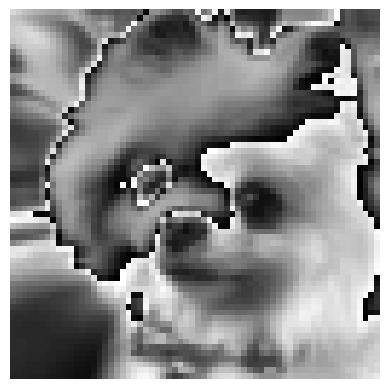

In [5]:
image_tensor = val_set[0][0]

# 我顯示一張圖片以確認資料載入正確
to_img = transforms.ToPILImage()
a = to_img(image_tensor)

plt.imshow(a, cmap='gray')
plt.axis('off')
plt.show()


### 4. 實作Early Stopping
定義 `EarlyStopping` 類別以避免模型過度擬合 (Overfitting)。
- 監控驗證損失 (Val Loss)。
- 若 Loss 改善，則儲存當前模型權重 (`save_checkpoint`)。
- 若 Loss 在 `patience` (容忍次數) 內未改善，則標記 `early_stop` 為 True 以中斷訓練。

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0, path='best_model.pt'):
        self.patience = patience    # 容忍次數
        self.delta = delta       # 最小改善幅度
        self.path = path        # 模型儲存路徑
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        # 初始化最佳Loss
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        # Loss未改善，counter+1
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        # Loss改善，重置counter並存檔
        else:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        # 儲存模型權重
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...')
        self.best_loss = val_loss

### 5. 定義 CNN 模型架構
建立一個繼承自 `nn.Module` 的卷積神經網路：
- **特徵提取**：包含 3 層卷積層 (Conv2d)，每層後接 Batch Normalization、ReLU 激活函數與 Dropout (防止過擬合)。
- **降維**：使用 MaxPool2d 進行池化。
- **分類器**：將特徵展平後，通過兩個全連接層 (Linear) 輸出 3 個類別的分數。  
最後建立模型並移至GPU。

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 卷積層 1: 1 -> 16 channels
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv1_bn = nn.BatchNorm2d(16)

        # 卷積層 2: 16 -> 32 channels
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv2_bn = nn.BatchNorm2d(32)

        # 卷積層 3: 32 -> 64 channels
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv3_bn = nn.BatchNorm2d(64)

        # 池化與全連接層
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 29 * 29, 64)
        self.fc2 = nn.Linear(64, 3)
        self.dropOut = nn.Dropout(0.2)

    def forward(self, x):
        # 卷積 -> BN -> ReLU -> Dropout
        x = self.dropOut(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.dropOut(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.dropOut(F.relu(self.conv3_bn(self.conv3(x))))

        # 展平與全連接
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 建立模型並移至GPU
net = Net().to(device)

### 6. 執行訓練與驗證迴圈
設定損失函數 (CrossEntropyLoss) 與優化器 (SGD)。
進行 50 個 Epoch 的訓練流程：
1. **訓練階段**：前向傳播、計算 Loss、反向傳播更新權重。
2. **驗證階段**：計算驗證集的 Loss 與 Accuracy，不更新權重。
3. **early stopping**：呼叫 `early_stopping` 物件，若驗證效果未改善則提早結束訓練。
過程中的各項指標會被記錄在 list 中以供後續繪圖。

In [ ]:
# 定義Loss函數與優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

# 初始化early stopping物件 (容忍次數=5)
early_stopping = EarlyStopping(patience=5, path='best_model.pt')

epochs = 50
epoch_log = []
loss_log = []
val_loss_log = []
accuracy_log = []

for epoch in range(epochs):
    print(f'Starting Epoch: {epoch+1}...')

    # --- 訓練階段 ---
    net.train()
    running_loss = 0.0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainloader)

    # --- 驗證階段 ---
    net.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(valloader)
    val_acc = 100 * correct / total

    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val Loss: {val_loss:.3f}, Val Acc: {val_acc:.3f}%')

    # 紀錄數據
    epoch_log.append(epoch+1)
    loss_log.append(train_loss)
    val_loss_log.append(val_loss)
    accuracy_log.append(val_acc)

    # --- 早停檢查 ---
    early_stopping(val_loss, net)

    if early_stopping.early_stop:
        print("Early stopping triggered! Training stopped.")
        break

print('Finished Training')

### 7. 載入最佳權重與最終測試
訓練結束後，載入 `EarlyStopping` 保存的 `best_model.pt` (驗證損失最低的模型權重)，確保使用的是表現最好的模型。
接著使用獨立的 **測試集 (Test Set)** 進行推論，計算並印出最終的準確率 (Accuracy)。

In [9]:
# 載入最佳模型權重
net.load_state_dict(torch.load('best_model.pt'))
print("Loaded best model from validation phase.")

# --- 最終測試 ---
net.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Final Accuracy on Test Set: {accuracy:.2f}%')

Loaded best model from validation phase.
Final Accuracy on Test Set: 97.53%


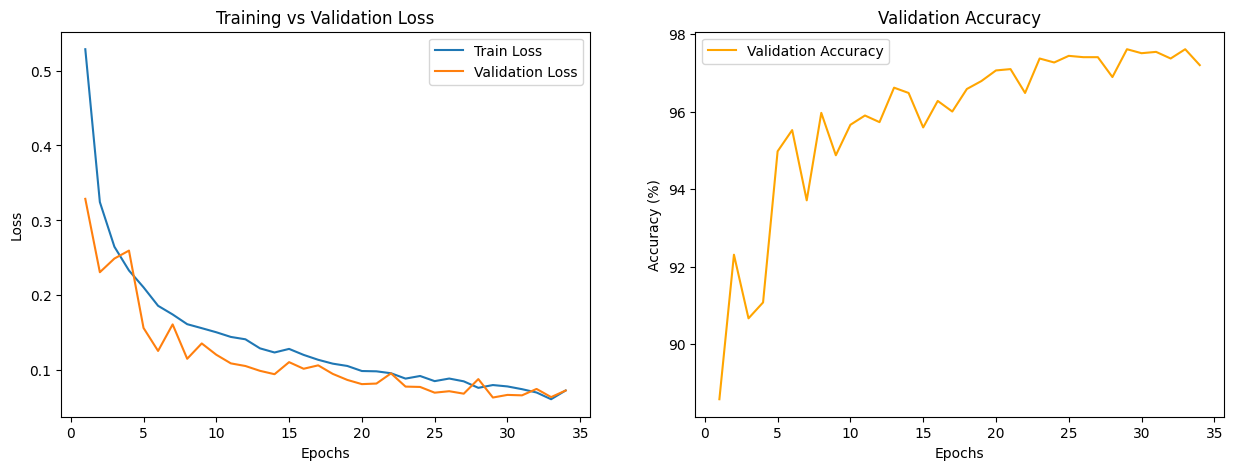

In [11]:
plt.figure(figsize=(15, 5))

# --- 子圖 1: Loss 變化曲線 ---
plt.subplot(1, 2, 1)
plt.plot(epoch_log, loss_log, label='Train Loss')
plt.plot(epoch_log, val_loss_log, label='Validation Loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# --- 子圖 2: Accuracy 變化曲線 ---
plt.subplot(1, 2, 2)
plt.plot(epoch_log, accuracy_log, label='Validation Accuracy', color='orange')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.show()